## Demo: Clock check - for offsets in instrument clocks

This is an intermediate step between stage1 and stage 2.  We are trying to determine whether the timestamps for any of the instruments on the same mooring are incorrect.  This is slightly faulty because they could *all* be wrong, unless we are comparing against UTC or have more exact timing knowledge.  For more exact timing knowledge, the deployment time and recovery time (anchor release, either dropping from the ship or release from the seabed) have been added to the yaml file in UTC.  This can be compared against the times estimated through lag correlations.

### This notebook 

**It does not change anything in the data files.**  You run this notebook in order to update the field `clock_offset` (in seconds) in the YAML file for each instrument on a mooring.  This is normally due to the instruments being set up incorrectly (i.e., with a clock time that did not match UTC).

After determining the appropriate clock offset, then run the stage2 processing to apply the clock offset to the netCDF files for each instrument.

Then, running this notebook again using the stage2 files (`*_use.nc`) should predict no additional clock offsets.

Clock offset is in integer seconds ADDED to the original instrument time.  I.e., shifts the record later.

### Main check

- We look at when--according to the instrument clocks--the `temperature` values are cold.  This assumes that in the middle of the record, the temperatures are colder than the near-surface temperatures (may fail for polar deployments).  Cold is within the mean +- 3 * std of the deep values.

- Then check when the instrument first reads a temperature within those bounds: `start_time`
- And check when the instrument last reads a temperature within those bounds: `end_time`

Check whether the first timestamp within the cold water for that instrument is similar in time to the first timestamp for another instrument.  This should be reasonably good at getting large offsets in clocks.

### Secondary check

- We interpolate data onto a common time grid (rough and ready)
- Check for lag correlation between instruments, and use this to estimate an offset

In [1]:
import os

import yaml
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime

from oceanarray import tools

## Load data for one mooring into datasets, list of xarray datasets

In [15]:
# Specify the base directory.  raw is a subdirectory from here moor/raw/ and proc is moor/proc
basedir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'
output_path = basedir + 'moor/proc/'

# Toggle to load the *_raw.nc or the *_use.nc
file_subscript = '_raw'
file_subscript = '_use'
print(f"Using files with {file_subscript}")

moorlist = ['ds2_X_2012','ds2_X_2017','ds2_X_2018',
            'ds8_1_2012','ds9_1_2012','ds10_1_2012', 'ds11_1_2012','ds12_1_2012',
            'ds13_1_2012','ds14_1_2012','ds15_1_2012','ds16_1_2012','ds17_1_2012',
            'ds19_1_2012','ds18_1_2012','ds28_1_2017',
            'dsA_1_2018','dsB_1_2018','dsC_1_2018', 'dsD_1_2018','dsE_1_2018','dsF_1_2018',
            'dsM1_1_2017','dsM2_1_2017','dsM3_1_2017','dsM4_1_2017','dsM5_1_2017']
moorlist = ['dsC_1_2018']

# Cycle through the yaml and load instrument data into a list of xarray datasets
# Enrich the netCDF with information from the yaml file
# Find the mooring's processed directory & read the yaml specification
name1 = moorlist[0]
proc_dir = output_path + name1
moor_yaml = proc_dir + '/' + name1 + '.mooring.yaml'
with open(moor_yaml, 'r') as f:
    moor_yaml_data = yaml.safe_load(f)

# For each instrument, load the raw netCDF files and add some metadata from the yaml
datasets = []
for i in moor_yaml_data['instruments']:
    fname = name1 + '_' + str(i['serial']) + file_subscript + '.nc'
    rawfile = proc_dir + '/' + i['instrument'] + '/' + fname

    if os.path.exists(rawfile):
        ds1 = xr.open_dataset(rawfile)

        if 'InstrDepth' not in ds1.variables and 'depth' in i:
            ds1['InstrDepth'] = i['depth']
        if 'instrument' not in ds1.variables and 'instrument' in i:
            ds1['instrument'] = i['instrument']
        if 'serial_number' not in ds1.variables and 'serial' in i:
            ds1['serial_number'] = i['serial']
        if 'timeS' in ds1.variables:
            ds1 = ds1.drop_vars('timeS')
        #---------------------------------------------
        # Store the data in a list of datasets
        datasets.append(ds1)

# Collect some timing info for each instrument
intervals_min = []
start_times = []
end_times = []
# For each dataset, write the coverage
for idx, ds in enumerate(datasets):
    time = ds['time']
    start_time = str(time.values[0])
    end_time = str(time.values[-1])
    time_interval = (time.values[1] - time.values[0]) / np.timedelta64(1, 'm')
    time_interval = np.nanmedian(np.diff(time.values) / np.timedelta64(1, 'm') )
    if time_interval > 1:
        tstr = f"{time_interval:1.2f} min"
    else:
        tstr = f"{time_interval * 60:1.2f} sec"
    variables = list(ds.data_vars)
    print(f"Dataset {idx} depth {str(ds['InstrDepth'].values)} [{ds['instrument'].values}:{ds['serial_number'].values}]:")
    print(f"  Start time: {start_time[0:19]}.  End time:   {end_time[0:19]}.  Time interval: {tstr}")
    print(f"  Coordinates: {list(ds.coords)}.  Variables: {variables}")

    #---------------------------------------------
    # Save the interval for later use
    intervals_min.append(time_interval)
    start_times.append(time.values[0])
    end_times.append(time.values[-1])

earliest_start = min(start_times)
latest_end = max(end_times)
time_grid = np.arange(earliest_start, latest_end, np.timedelta64(int(np.nanmedian(intervals_min) * 60), 's'))

print(f"Time grid length: {len(time_grid)}")
print(f"First time: {time_grid[0]}")
print(f"Last time: {time_grid[-1]}")



Using files with _use
Dataset 0 depth 837 [sbe56:6368]:
  Start time: 2018-08-13T12:00:00.  End time:   2018-08-28T09:09:29.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 1 depth 887 [sbe56:7091]:
  Start time: 2018-08-12T12:00:00.  End time:   2018-08-28T10:00:09.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 2 depth 897 [sbe56:6391]:
  Start time: 2018-08-13T12:00:00.  End time:   2018-08-28T10:02:18.  Time interval: 10.02 sec
  Coordinates: ['time', 'latitude', 'longitude'].  Variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number', 'clock_offset']
Dataset 3 depth 907 [sbe56:6393]:
  Start time: 2018-08-13T12:00:00.  End time:   2018-08-28T10:09:19.  Time

# Interpolate dataset

Here we interpolate data onto the same time grid to simply checking for clock offsets (in a later step)

In [3]:
datasets_interp = []
for idx, ds in enumerate(datasets):
    print(f"Dataset {idx}:")
    print(f"  Dimensions: {dict(ds.sizes)},  Coordinates: {list(ds.coords)},  Data variables: {list(ds.data_vars)}")

    # Check if this dataset has a time dimension
    if 'time' not in ds.sizes:
        print(f"  WARNING: Dataset {idx} has no time dimension, skipping interpolation")
        continue

    # Check if time dimension has more than one element
    if ds.sizes['time'] <= 1:
        print(f"  WARNING: Dataset {idx} has only {ds.sizes['time']} time point(s), skipping interpolation")
        continue

    try:
        # Select only the variables present in the dataset that have time dimension
        interp_vars = {}
        for var in ds.data_vars:
            if 'time' in ds[var].dims:
                interp_vars[var] = ds[var].interp(time=time_grid)
            else:
                interp_vars[var] = ds[var]  # Keep variables without time dimension as is

        if interp_vars:  # Only create dataset if we have variables to interpolate
            # Create a new dataset with interpolated variables and replace the time coordinate
            ds_interp = xr.Dataset(interp_vars, coords={'time': time_grid})

            # Add depth and other metadata as coordinates (not variables with time dimension)
            if 'InstrDepth' in ds:
                ds_interp = ds_interp.assign_coords(depth=ds['InstrDepth'])
            if 'clock_offset' in ds:
                ds_interp = ds_interp.assign_coords(seconds_offset=ds['clock_offset'])

            datasets_interp.append(ds_interp)
            #print(f"  Successfully interpolated dataset {idx}")
        else:
            print(f"  No time-dependent variables found in dataset {idx}")

    except Exception as e:
        print(f"  ERROR interpolating dataset {idx}: {e}")
        continue

print(f"\nSuccessfully interpolated {len(datasets_interp)} out of {len(datasets)} datasets")

datasets_interp[0]

Dataset 0:
  Dimensions: {'time': 128578},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number']
Dataset 1:
  Dimensions: {'time': 137522},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number']
Dataset 2:
  Dimensions: {'time': 128895},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number']
Dataset 3:
  Dimensions: {'time': 128937},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number']
Dataset 4:
  Dimensions: {'time': 128925},  Coordinates: ['time', 'latitude', 'longitude'],  Data variables: ['temperature', 'julian_days_offset', 'InstrDepth', 'instrument', 'serial_number']
Dataset 5:
  Dimensions: {'time': 128851

<xarray.Dataset> Size: 3MB
Dimensions:             (time: 137576)
Coordinates:
    latitude            float64 8B ...
    longitude           float64 8B ...
  * time                (time) datetime64[ns] 1MB 2018-08-12T12:00:00 ... 201...
    depth               int64 8B 837
Data variables:
    temperature         (time) float64 1MB nan nan nan nan ... nan nan nan nan
    julian_days_offset  (time) float64 1MB nan nan nan nan ... nan nan nan nan
    InstrDepth          int64 8B 837
    instrument          <U5 20B 'sbe56'
    serial_number       int64 8B 6368

# Combine interpolated datasets

In [4]:
# List of variables to keep
vars_to_keep = ['temperature', 'salinity', 'conductivity', 'pressure', 'u_velocity','v_velocity']#,'serial_number','InstrDepth']

# Remove unwanted variables from each dataset
datasets_clean = []
for ds in datasets_interp:
    ds_sel = ds.drop_vars(['density', 'potential_temperature', 'julian_days_offset','timeS'], errors='ignore')
    datasets_clean.append(ds_sel)

# Find union of all time coordinates (should be the same for all, but let's check)
time_coord = datasets_interp[0]['time']

# Prepare data arrays for each variable
combined_data = {}
N_LEVELS = len(datasets_clean)

for var in vars_to_keep:
    arrs = []
    for ds in datasets_clean:
        if var in ds:
            arrs.append(ds[var].values)
        else:
            arrs.append(np.full(time_coord.shape, np.nan))
    # Stack along new N_LEVELS dimension
    combined_data[var] = (('time', 'N_LEVELS'), np.stack(arrs, axis=-1))

# Gather scalar variables for each level
depths = []
clock_offsets = []
serial = []
instrtype = []
for ds in datasets_clean:
    # depth: if missing, use NaN
    depths.append(float(ds["InstrDepth"].item()) if "InstrDepth" in ds else np.nan)
    serial.append(ds['serial_number'].item() if "serial_number" in ds else np.nan)
    instrtype.append(ds['instrument'].item() if "instrument" in ds else 'unknown'  )
    # clock offset: prefer 'clock_offset', fall back to legacy 'seconds_offset', else 0
    if "clock_offset" in ds:
        co = ds["clock_offset"].item()
    elif "seconds_offset" in ds:
        co = ds["seconds_offset"].item()
    else:
        co = 0
    # cast safely; NaN -> 0
    clock_offsets.append(int(np.rint(co)) if np.isfinite(co) else 0)

# Create the combined dataset
combined_ds = xr.Dataset(
    data_vars=combined_data,
    coords={
        'time': time_coord,
        'N_LEVELS': np.arange(N_LEVELS),
        'clock_offset': ('N_LEVELS', np.array(clock_offsets)),
        'serial_number': ('N_LEVELS', np.array(serial)),
        'nominal_depth': ('N_LEVELS', np.array(depths)),
        "instrument": ("N_LEVELS", np.asarray(instrtype)),  # <-- 1-D


    }
)



In [5]:
combined_ds

<xarray.Dataset> Size: 166MB
Dimensions:        (time: 137576, N_LEVELS: 25)
Coordinates:
    latitude       float64 8B ...
    longitude      float64 8B ...
  * time           (time) datetime64[ns] 1MB 2018-08-12T12:00:00 ... 2018-08-...
    depth          int64 8B 837
  * N_LEVELS       (N_LEVELS) int64 200B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24
    clock_offset   (N_LEVELS) int64 200B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 85700 0
    serial_number  (N_LEVELS) int64 200B 6368 7091 6391 6393 ... 7516 9057 6399
    nominal_depth  (N_LEVELS) float64 200B 837.0 887.0 ... 1.096e+03 1.125e+03
    instrument     (N_LEVELS) <U8 800B 'sbe56' 'sbe56' ... 'aquadopp' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 28MB nan 21.73 nan ... nan nan nan
    salinity       (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan

## Identify likely start and end of DEPLOYED period (on the bottom)

In [ ]:
if 0:
    import importlib
    importlib.reload(tools)

    combined_ds = tools.find_deployment(combined_ds, var_name='temperature')
    combined_ds

    # Get the median of combined_ds['start_time']
    def median_times(time_array):
        times_as_float = time_array.astype('datetime64[ns]').astype('float')
        median_time = np.nanmedian(times_as_float)
        median_as_datetime = median_time.astype('datetime64[ns]')
        return median_as_datetime

    mean_start_time = median_times(combined_ds['start_time'])
    mean_end_time = median_times(combined_ds['end_time'])
    print(f"Median start time is {mean_start_time}")
    print(f"Median end time is {mean_end_time}")

    combined_ds.attrs['start_time'] = mean_start_time
    combined_ds.attrs['end_time'] = mean_end_time

    combined_ds

0/6368:sbe56: Split at 7.47.  Start after 2018-08-13T19:55:40.000000000.  End with 2018-08-27T13:03:40.000000000.
1/7091:sbe56: Split at 3.30.  Start after 2018-08-14T11:48:00.000000000.  End with 2018-08-26T21:35:00.000000000.
2/6391:sbe56: Split at 3.16.  Start after 2018-08-14T11:48:30.000000000.  End with 2018-08-26T20:43:00.000000000.
3/6393:sbe56: Split at 3.16.  Start after 2018-08-14T11:43:50.000000000.  End with 2018-08-26T20:49:10.000000000.
4/6407:sbe56: Split at 5.90.  Start after 2018-08-13T19:59:50.000000000.  End with 2018-08-27T12:59:40.000000000.
5/6404:sbe56: Split at 5.78.  Start after 2018-08-13T19:59:50.000000000.  End with 2018-08-27T12:59:30.000000000.
6/6406:sbe56: Split at 5.83.  Start after 2018-08-13T19:59:40.000000000.  End with 2018-08-27T12:59:30.000000000.
7/6392:sbe56: Split at 1.54.  Start after 2018-08-14T10:12:20.000000000.  End with 2018-08-26T18:40:50.000000000.
8/1167:sbe16: Split at 1.93.  Start after 2018-08-14T08:57:30.000000000.  End with 2018-

<xarray.Dataset> Size: 166MB
Dimensions:        (time: 137576, N_LEVELS: 25)
Coordinates:
    latitude       float64 8B ...
    longitude      float64 8B ...
  * time           (time) datetime64[ns] 1MB 2018-08-12T12:00:00 ... 2018-08-...
    depth          int64 8B 837
  * N_LEVELS       (N_LEVELS) int64 200B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24
    clock_offset   (N_LEVELS) int64 200B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 85700 0
    serial_number  (N_LEVELS) int64 200B 6368 7091 6391 6393 ... 7516 9057 6399
    nominal_depth  (N_LEVELS) float64 200B 837.0 887.0 ... 1.096e+03 1.125e+03
    instrument     (N_LEVELS) <U8 800B 'sbe56' 'sbe56' ... 'aquadopp' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 28MB nan 21.73 nan ... nan nan nan
    salinity       (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS) datetime64[ns] 200B 2018-08-13T19:55:40 ... 201...
    end_time       (N_LEVELS) datetime64[ns] 200B 2018-08-27T13:03:40 ... 201...
    split_value    (N_LEVELS) float64 200B 7.47 3.303 3.156 ... 2.633 2.658
    split_value2   (N_LEVELS) float64 200B 19.24 20.18 19.99 ... 3.96 19.01
Attributes:
    start_time:  2018-08-13T20:04:20.000000000
    end_time:    2018-08-27T04:53:20.000000000

In [7]:
from oceanarray import find_deployment
importlib.reload(find_deployment)

combined_ds = find_deployment.find_deployment(combined_ds,bottom_strategy="deployment_bounds",
    deployment_time=ds.attrs.get("deployment_time"),
    recovery_time=ds.attrs.get("recovery_time"))


0/6368:sbe56: Split at 7.37.  Start after 2018-08-13T19:55:50.000000000.  End with 2018-08-27T13:03:40.000000000.
1/7091:sbe56: Split at 7.56.  Start after 2018-08-13T19:55:00.000000000.  End with 2018-08-27T13:04:20.000000000.
2/6391:sbe56: Split at 7.58.  Start after 2018-08-13T19:54:50.000000000.  End with 2018-08-27T13:04:20.000000000.
3/6393:sbe56: Split at 7.61.  Start after 2018-08-13T19:54:40.000000000.  End with 2018-08-27T13:04:30.000000000.
4/6407:sbe56: Split at 7.66.  Start after 2018-08-13T19:54:40.000000000.  End with 2018-08-27T13:33:20.000000000.
5/6404:sbe56: Split at 7.71.  Start after 2018-08-13T19:54:30.000000000.  End with 2018-08-27T13:33:50.000000000.
6/6406:sbe56: Split at 7.77.  Start after 2018-08-13T19:54:30.000000000.  End with 2018-08-27T13:34:20.000000000.
7/6392:sbe56: Split at 7.81.  Start after 2018-08-13T19:54:20.000000000.  End with 2018-08-27T13:34:30.000000000.
8/1167:sbe16: Split at 7.92.  Start after 2018-08-13T19:54:00.000000000.  End with 2018-

/Users/eddifying/Cloudfree/github/oceanarray/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


10/7090:sbe56: Split at 7.76.  Start after 2018-08-13T19:54:20.000000000.  End with 2018-08-27T13:37:10.000000000.
11/6395:sbe56: Split at 7.66.  Start after 2018-08-13T19:54:10.000000000.  End with 2018-08-27T13:04:00.000000000.
12/6367:sbe56: Split at 7.50.  Start after 2018-08-13T19:54:10.000000000.  End with 2018-08-27T13:03:50.000000000.
13/6371:sbe56: Split at 7.32.  Start after 2018-08-13T19:54:10.000000000.  End with 2018-08-27T13:03:50.000000000.
14/6372:sbe56: Split at 7.12.  Start after 2018-08-13T19:54:40.000000000.  End with 2018-08-27T13:03:20.000000000.
15/15176:microcat: Split at 6.77.  Start after 2018-08-13T19:56:00.000000000.  End with 2018-08-27T13:02:10.000000000.
16/4774:aquadopp: Split at 6.71.  Start after 2018-08-13T19:54:20.000000000.  End with 2018-08-27T12:57:10.000000000.
17/6408:sbe56: Split at 6.47.  Start after 2018-08-13T19:57:10.000000000.  End with 2018-08-27T13:01:10.000000000.
18/6403:sbe56: Split at 6.20.  Start after 2018-08-13T19:57:30.000000000.

In [8]:
combined_ds

<xarray.Dataset> Size: 166MB
Dimensions:        (time: 137576, N_LEVELS: 25)
Coordinates:
    latitude       float64 8B ...
    longitude      float64 8B ...
  * time           (time) datetime64[ns] 1MB 2018-08-12T12:00:00 ... 2018-08-...
    depth          int64 8B 837
  * N_LEVELS       (N_LEVELS) int64 200B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24
    clock_offset   (N_LEVELS) int64 200B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 85700 0
    serial_number  (N_LEVELS) int64 200B 6368 7091 6391 6393 ... 7516 9057 6399
    nominal_depth  (N_LEVELS) float64 200B 837.0 887.0 ... 1.096e+03 1.125e+03
    instrument     (N_LEVELS) <U8 800B 'sbe56' 'sbe56' ... 'aquadopp' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 28MB nan 21.73 nan ... nan nan nan
    salinity       (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    conductivity   (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    pressure       (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    u_velocity     (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 28MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS) datetime64[ns] 200B 2018-08-13T19:55:50 ... 201...
    end_time       (N_LEVELS) datetime64[ns] 200B 2018-08-27T13:03:40 ... 201...
    split_value    (N_LEVELS) float64 200B 7.372 7.556 7.576 ... 4.791 4.262
    split_value2   (N_LEVELS) float64 200B 19.24 20.18 19.99 ... 3.96 19.01
Attributes:
    start_time:  2018-08-13T20:04:20.000000000
    end_time:    2018-08-27T04:53:20.000000000

start time is 2018-08-13T19:55:50.000000000


/var/folders/t1/z5bp59k95119nw35yqv699t40000gn/T/ipykernel_26901/2312768844.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in range(ds.dims["N_LEVELS"]):


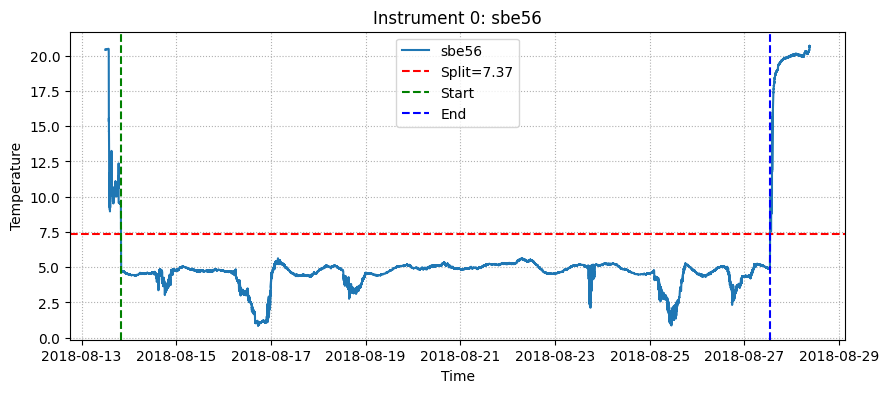

start time is 2018-08-13T19:55:00.000000000


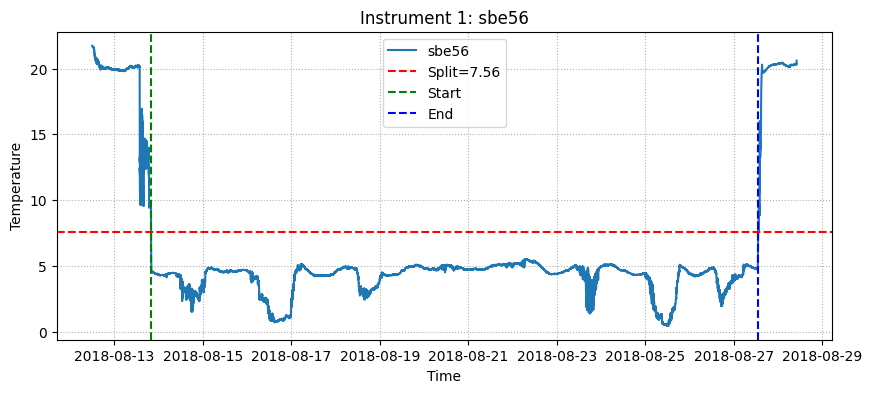

start time is 2018-08-13T19:54:50.000000000


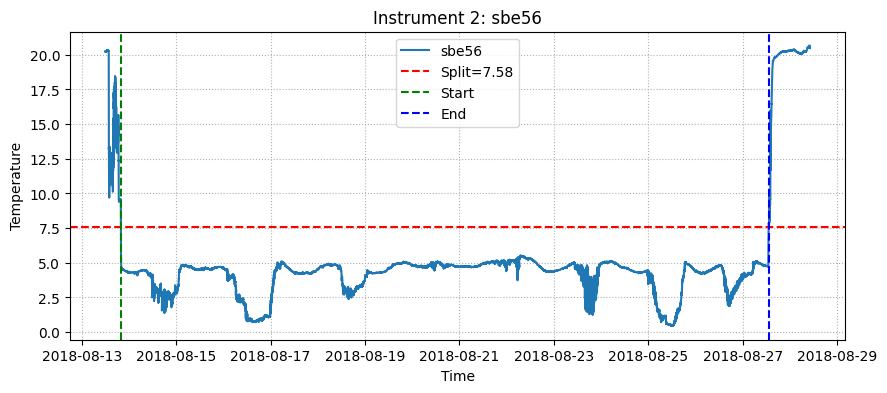

start time is 2018-08-13T19:54:40.000000000


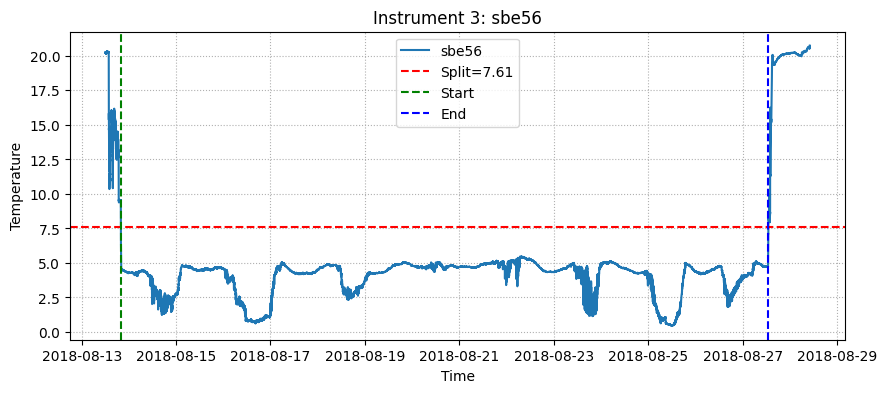

start time is 2018-08-13T19:54:40.000000000


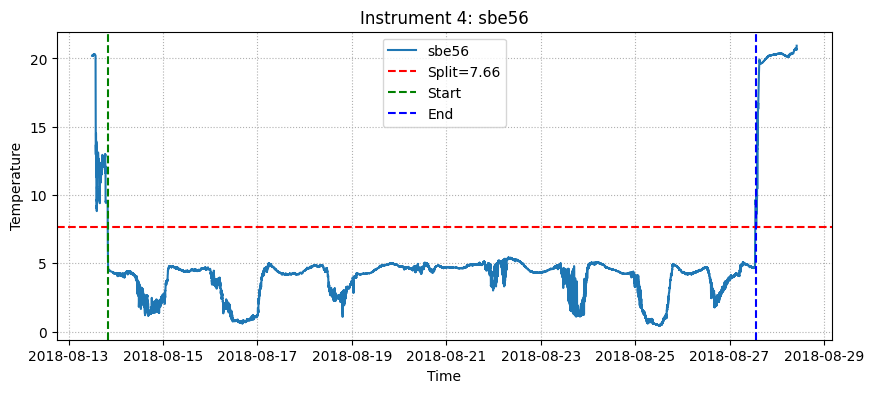

start time is 2018-08-13T19:54:30.000000000


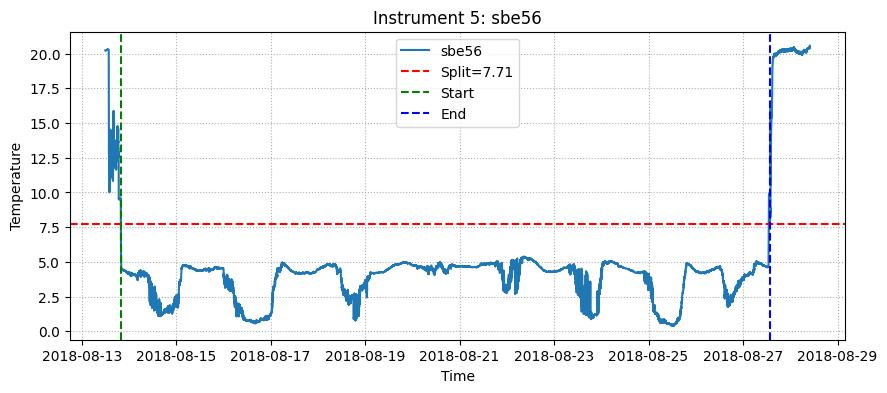

start time is 2018-08-13T19:54:30.000000000


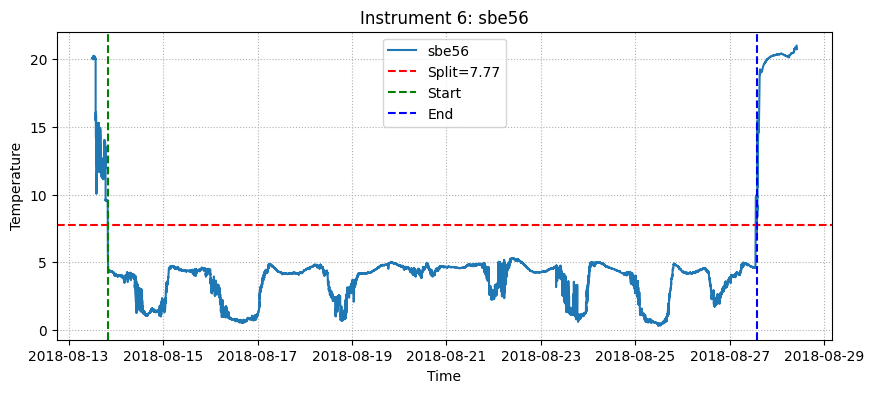

start time is 2018-08-13T19:54:20.000000000


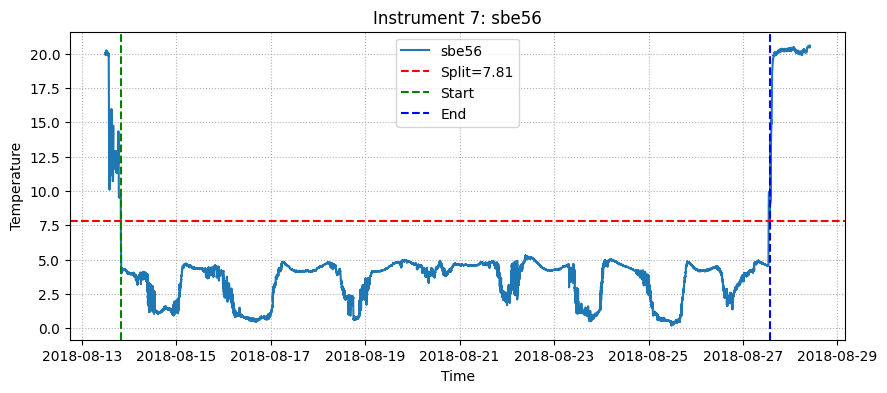

start time is 2018-08-13T19:54:00.000000000


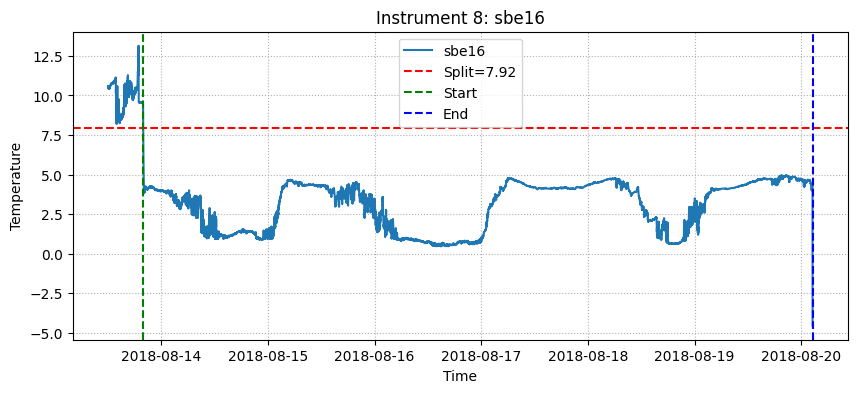

start time is 2018-08-13T19:51:00.000000000


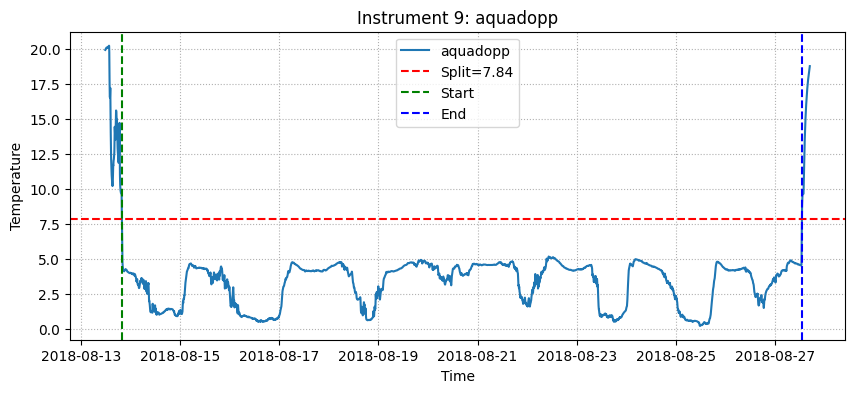

start time is 2018-08-13T19:54:20.000000000


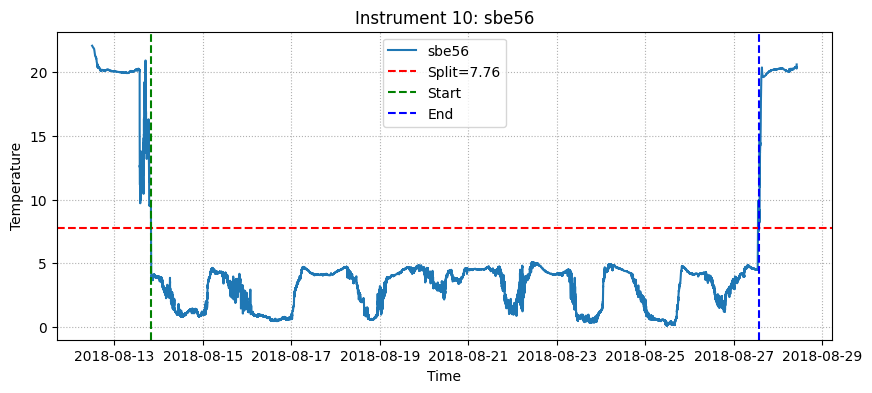

start time is 2018-08-13T19:54:10.000000000


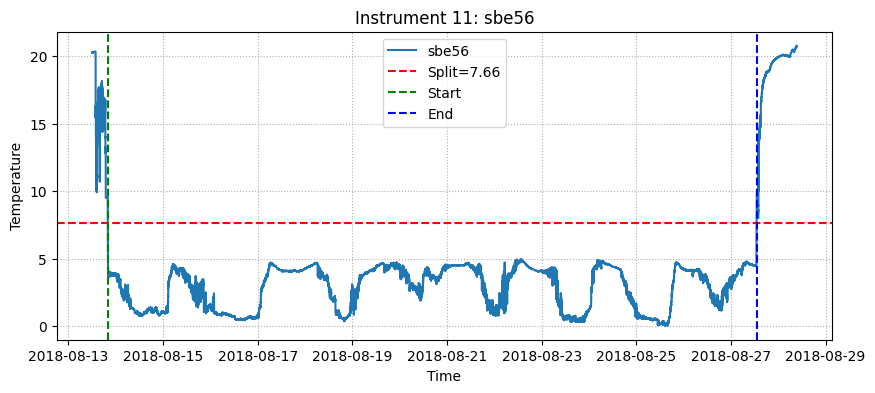

start time is 2018-08-13T19:54:10.000000000


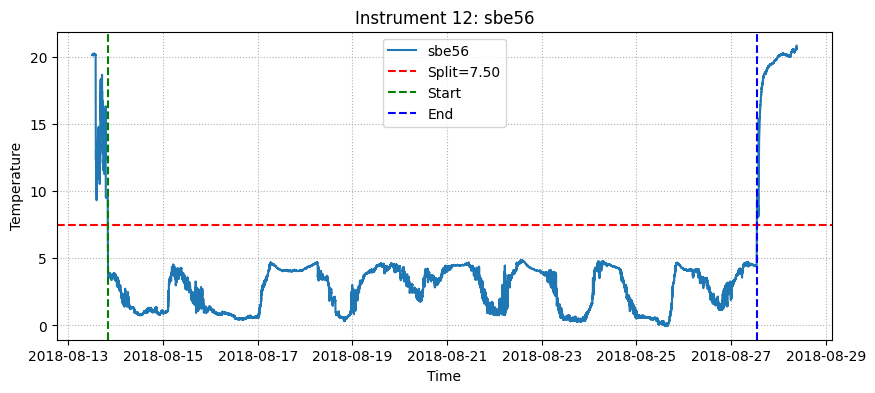

start time is 2018-08-13T19:54:10.000000000


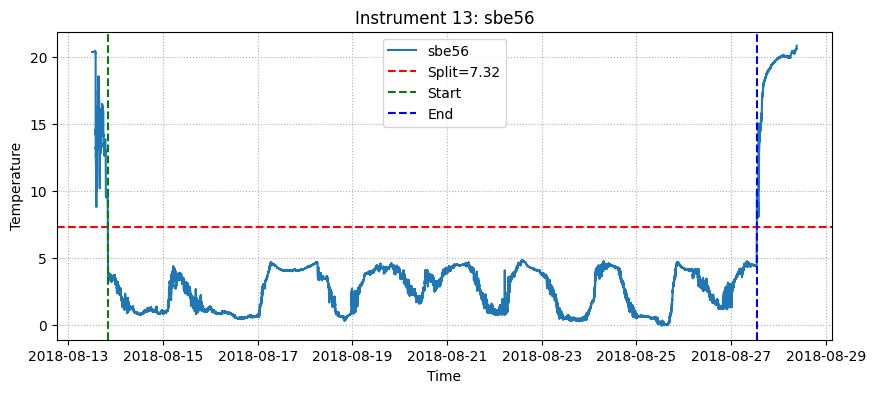

start time is 2018-08-13T19:54:40.000000000


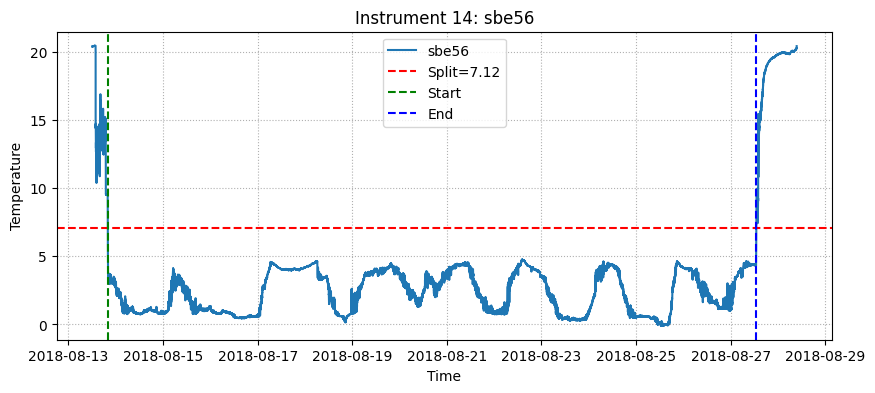

start time is 2018-08-13T19:56:00.000000000


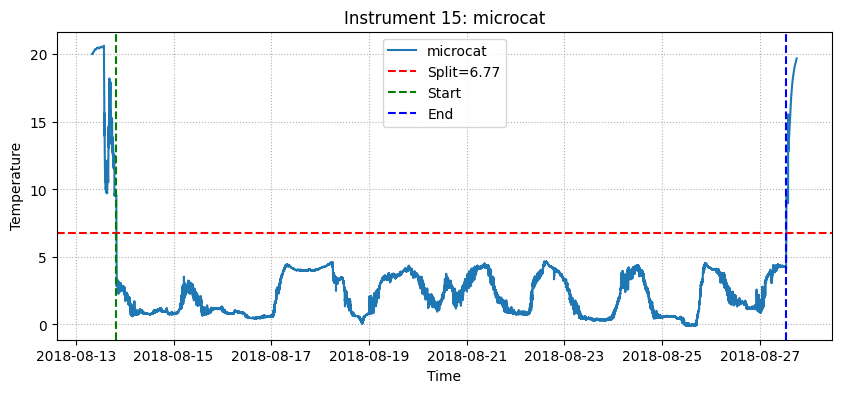

start time is 2018-08-13T19:54:20.000000000


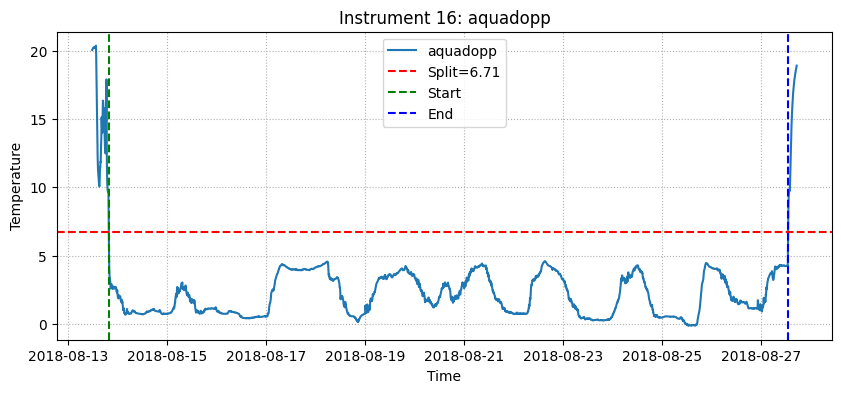

start time is 2018-08-13T19:57:10.000000000


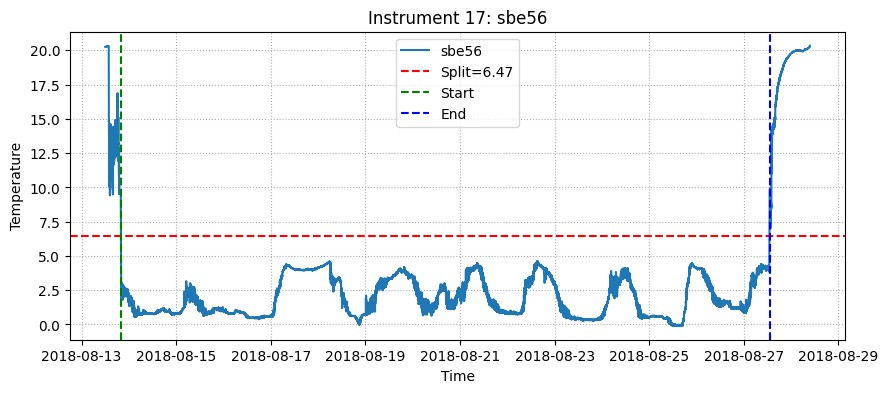

start time is 2018-08-13T19:57:30.000000000


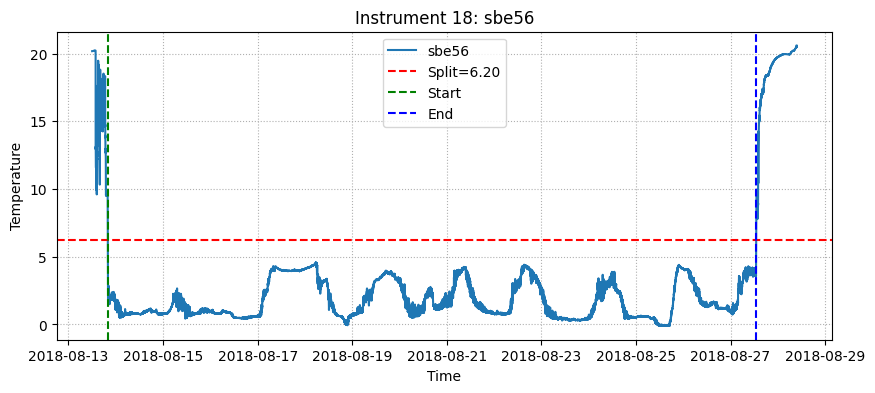

start time is 2018-08-13T19:58:10.000000000


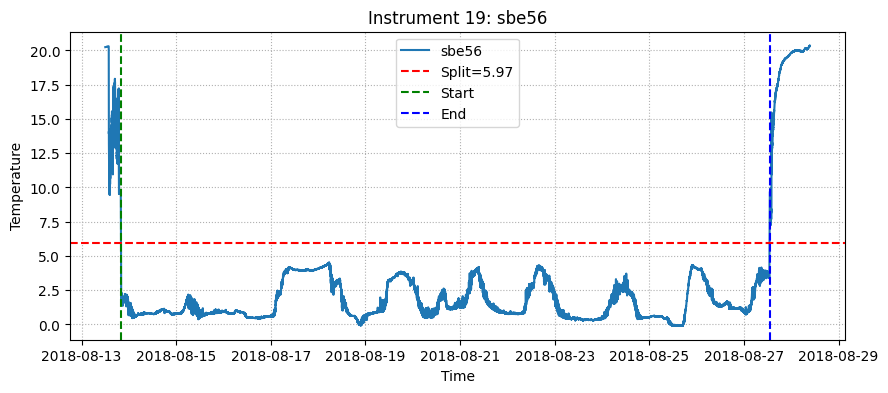

start time is 2018-08-13T19:58:40.000000000


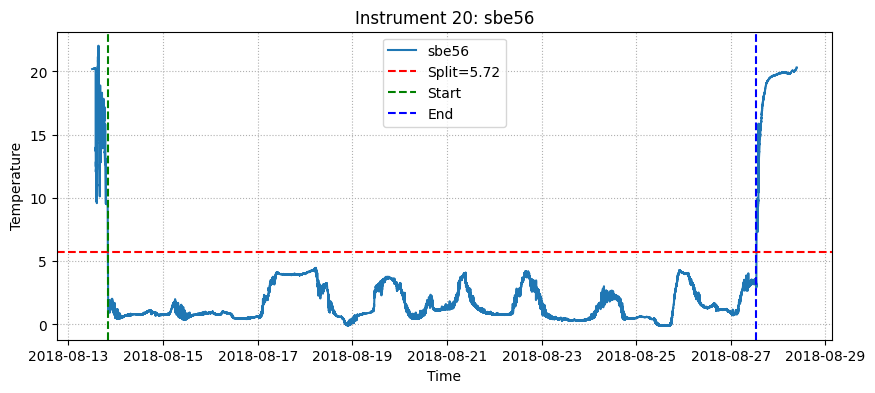

start time is 2018-08-13T19:59:20.000000000


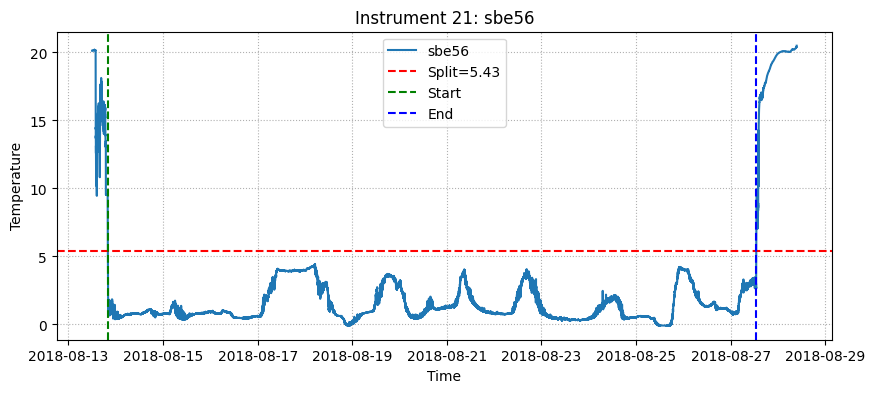

start time is 2018-08-13T20:01:50.000000000


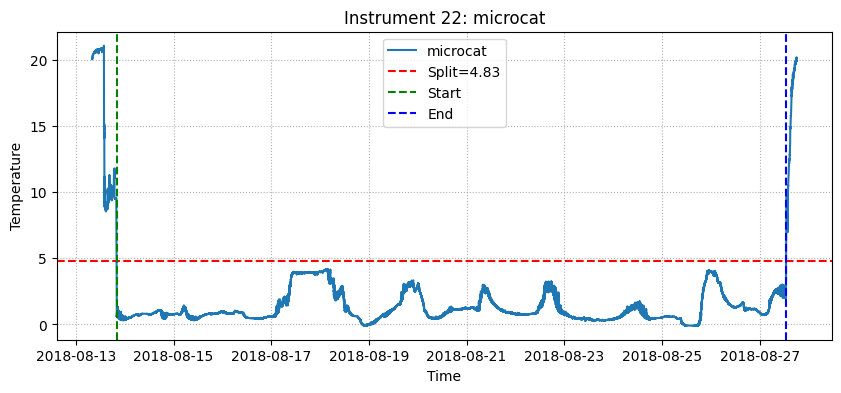

start time is 2018-08-13T19:57:20.000000000


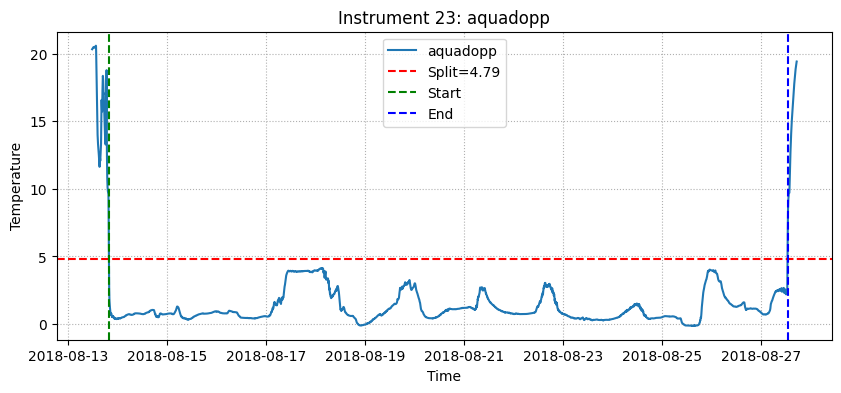

start time is 2018-08-13T20:02:20.000000000


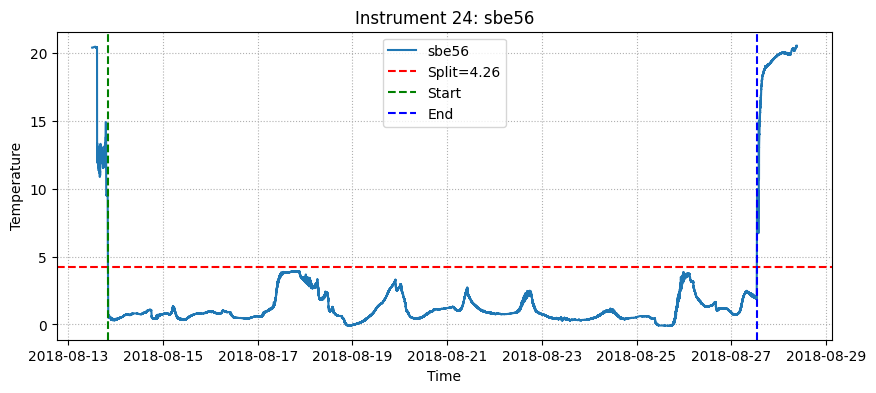

In [9]:
import matplotlib.pyplot as plt
ds = combined_ds
time        = ds["time"].values
temp        = ds["temperature"].values
split_vals  = ds["split_value"].values
instruments = ds["instrument"].values
start_times = ds["start_time"].values
end_times   = ds["end_time"].values

#for i in range(0,1):
for i in range(ds.dims["N_LEVELS"]):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(time, temp[:, i], label=f"{instruments[i]}")
    ax.axhline(split_vals[i], color="red", linestyle="--",
               label=f"Split={split_vals[i]:.2f}")

    # vertical lines for start/end times (if not NaT)
    if np.isfinite(start_times[i].astype("datetime64[ns]").astype("int64")):
        ax.axvline(start_times[i], color="green", linestyle="--", lw=1.5,
                   label="Start")
        print(f"start time is {start_times[i]}")
    if np.isfinite(end_times[i].astype("datetime64[ns]").astype("int64")):
        ax.axvline(end_times[i], color="blue", linestyle="--", lw=1.5,
                   label="End")


    ax.set_title(f"Instrument {i}: {instruments[i]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature")
    ax.legend()
    ax.grid(True, linestyle=":")

    plt.show()


In [10]:
import numpy as np
import pandas as pd

ds = combined_ds  # or your dataset

# --- pull times ---
start_times = pd.to_datetime(ds["start_time"].values)
end_times   = pd.to_datetime(ds["end_time"].values)

# finite masks
f_start = np.isfinite(start_times)
f_end   = np.isfinite(end_times)

# --- initial refs (global) just to compute provisional offsets for clustering ---
ref_start0 = start_times[f_start].min()
ref_end0   = end_times[f_end].max()

start_off0 = np.full(start_times.shape, np.nan, float)
end_off0   = np.full(end_times.shape,   np.nan, float)
start_off0[f_start] = (start_times[f_start] - ref_start0) / np.timedelta64(1, "s")
end_off0[f_end]     = (end_times[f_end]   - ref_end0)     / np.timedelta64(1, "s")

# --- consensus group on start offsets (bin to nearest 60 s) ---
bin_width = 60.0  # seconds
vals = start_off0[np.isfinite(start_off0)]
if vals.size == 0:
    raise RuntimeError("No finite start offsets to form consensus.")

vmin, vmax = vals.min(), vals.max()
bins = np.arange(vmin - bin_width, vmax + 2*bin_width, bin_width)
hist, edges = np.histogram(vals, bins=bins)
k = np.argmax(hist)
lo, hi = edges[k], edges[k+1]
in_consensus = (start_off0 >= lo) & (start_off0 < hi)

idx_consensus = np.where(in_consensus & f_start & f_end)[0]  # require both times finite
if idx_consensus.size == 0:
    # fallback: use all in the winning bin even if some lack end_times
    idx_consensus = np.where(in_consensus & f_start)[0]

# --- redefine refs from consensus group only ---
ref_start = start_times[idx_consensus].min()
ref_end   = end_times[idx_consensus].max()

# --- recompute offsets relative to NEW refs ---
start_off = (start_times - ref_start) / np.timedelta64(1, "s")
end_off   = (end_times   - ref_end)   / np.timedelta64(1, "s")
avg_off   = (start_off + end_off) / 2.0
diff_off  = start_off - end_off       # start vs end disagreement (drift hint)

# --- optional: drift rate (s/day), skip ones without both times ---
dur = (end_times - start_times) / np.timedelta64(1, "s")
drift_rate_per_day = np.full_like(avg_off, np.nan, dtype=float)
ok = np.isfinite(start_off) & np.isfinite(end_off) & np.isfinite(dur) & (dur > 0)
drift_rate_per_day[ok] = (end_off[ok] - start_off[ok]) / dur[ok] * 86400.0

# --- print summary ---
N = ds.sizes["N_LEVELS"]
labels = ds["instrument"].values if "instrument" in ds else np.arange(N)
serial = ds["serial_number"].values if "serial_number" in ds else "0"
print(f"Consensus group size: {idx_consensus.size}")
print(f"Consensus-derived refs -> ref_start={ref_start}, ref_end={ref_end}\n")

for i in range(N):
    tag = "REF" if i in idx_consensus else "-"
    s = start_off[i]; e = end_off[i]; a = avg_off[i]; d = diff_off[i]; dr = drift_rate_per_day[i]
    print(
        f"{i:02d}: {str(labels[i]):8s}/{str(serial[i]):6s} | "
        f"start={pd.to_datetime(start_times[i])} ({s:+8.0f}s) | "
        f"end={pd.to_datetime(end_times[i])} ({e:+8.0f}s) | "
        f"avg={a:+8.0f}s | diff={d:+6.0f}s | drift={'nan' if not np.isfinite(dr) else f'{dr:+.2f} s/day'} | {tag}"
    )


Consensus group size: 13
Consensus-derived refs -> ref_start=2018-08-13 19:54:00, ref_end=2018-08-27 13:37:10

00: sbe56   /6368   | start=2018-08-13 19:55:50 (    +110s) | end=2018-08-27 13:03:40 (   -2010s) | avg=    -950s | diff= +2120s | drift=-154.59 s/day | -
01: sbe56   /7091   | start=2018-08-13 19:55:00 (     +60s) | end=2018-08-27 13:04:20 (   -1970s) | avg=    -955s | diff= +2030s | drift=-148.02 s/day | -
02: sbe56   /6391   | start=2018-08-13 19:54:50 (     +50s) | end=2018-08-27 13:04:20 (   -1970s) | avg=    -960s | diff= +2020s | drift=-147.28 s/day | REF
03: sbe56   /6393   | start=2018-08-13 19:54:40 (     +40s) | end=2018-08-27 13:04:30 (   -1960s) | avg=    -960s | diff= +2000s | drift=-145.82 s/day | REF
04: sbe56   /6407   | start=2018-08-13 19:54:40 (     +40s) | end=2018-08-27 13:33:20 (    -230s) | avg=     -95s | diff=  +270s | drift=-19.66 s/day | REF
05: sbe56   /6404   | start=2018-08-13 19:54:30 (     +30s) | end=2018-08-27 13:33:50 (    -200s) | avg=     

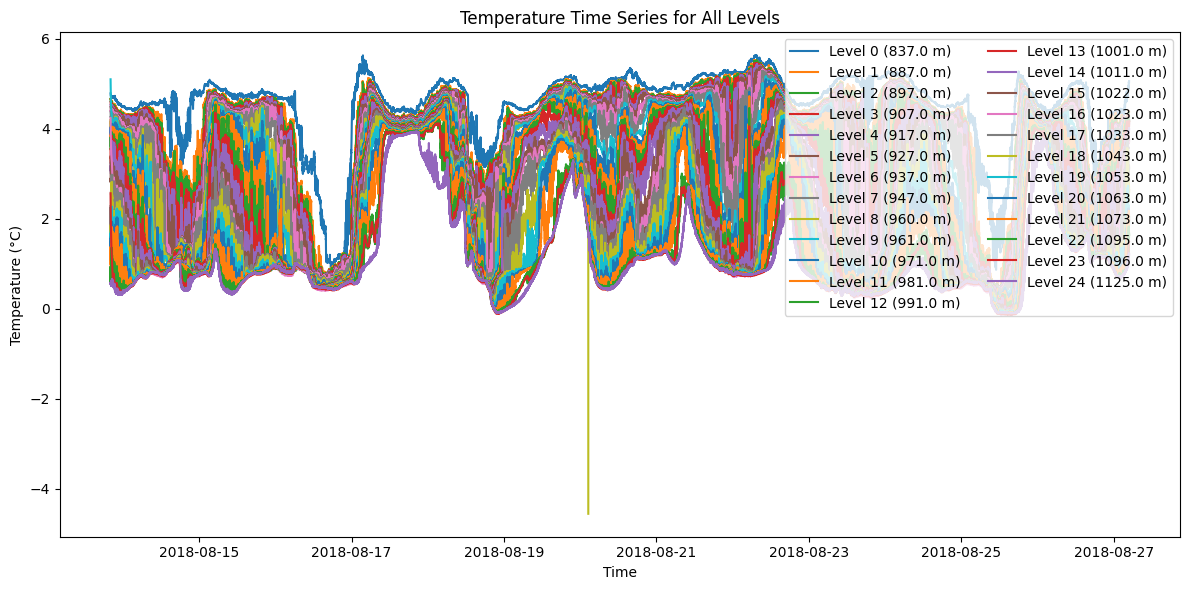

In [11]:
# Trim combined_ds to the period between start_time and end_time
combined_ds = combined_ds.where(combined_ds['time']>combined_ds.attrs['start_time'], drop=True)
combined_ds = combined_ds.where(combined_ds['time']<combined_ds.attrs['end_time'], drop=True)


# Plot a basic variable
time_interval = np.nanmedian(np.diff(combined_ds['time'].values) / np.timedelta64(1, 'm'))

plt.figure(figsize=(12, 6))
for i in range(combined_ds.sizes['N_LEVELS']):
    plt.plot(combined_ds['time'], combined_ds['temperature'][:, i], label=f'Level {i} ({depths[i]} m)')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Time Series for All Levels')
plt.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


Full length is 115493.  Subsampled length is 23099.
Level 1 (#6368): max correlation = 0.430 at lag = 153 --> clock_offset (sec): 7650.0
Level 2 (#7091): max correlation = 0.520 at lag = 87 --> clock_offset (sec): 4350.0
Level 3 (#6391): max correlation = 0.542 at lag = 78 --> clock_offset (sec): 3900.0
Level 4 (#6393): max correlation = 0.573 at lag = 70 --> clock_offset (sec): 3500.0
Level 5 (#6407): max correlation = 0.610 at lag = 58 --> clock_offset (sec): 2900.0
Level 6 (#6404): max correlation = 0.651 at lag = 49 --> clock_offset (sec): 2450.0
Level 7 (#6406): max correlation = 0.694 at lag = 34 --> clock_offset (sec): 1700.0
Level 8 (#6392): max correlation = 0.740 at lag = 1 --> clock_offset (sec): 50.0
Level 9 (#1167): max correlation = 0.821 at lag = 0 --> clock_offset (sec): 0.0
Level 10 (#4771): max correlation = 0.803 at lag = 6 --> clock_offset (sec): 300.0
Level 11 (#7090): max correlation = 0.853 at lag = 0 --> clock_offset (sec): 0.0
Level 12 (#6395): max correlation 

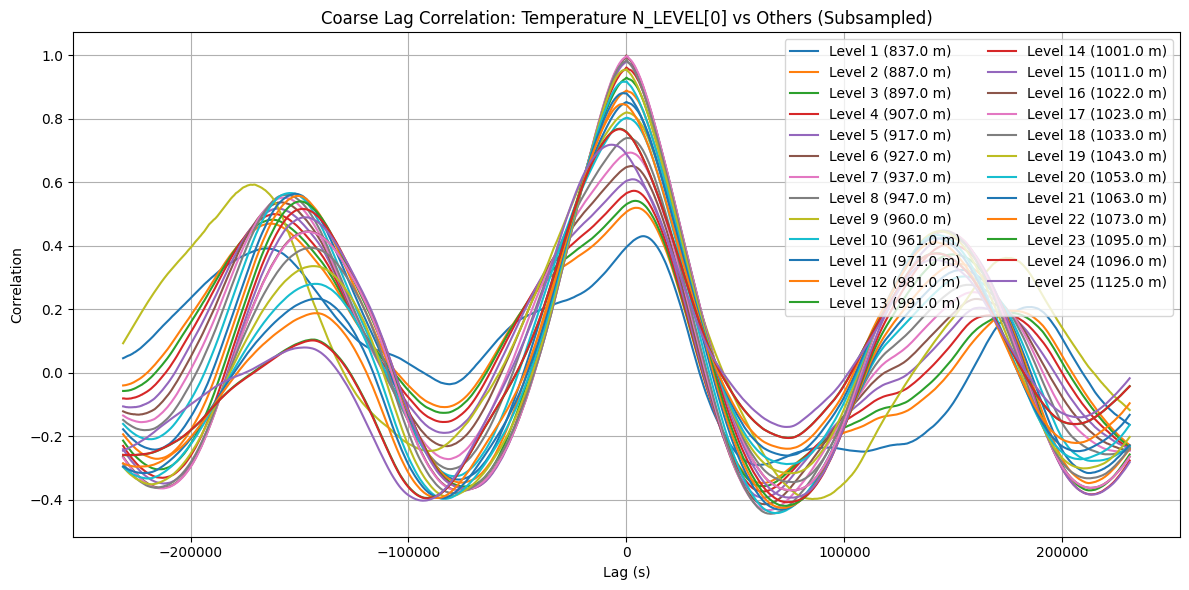

In [12]:
import importlib
importlib.reload(tools)
time_interval = np.nanmedian(np.diff(combined_ds['time'].values) / np.timedelta64(1, 's'))

# Subsample time series
sub_sample = 5


ref_index = 15

n_full = len(combined_ds['temperature'][:, ref_index].values)
ref_temp_sub = combined_ds['temperature'][:, ref_index].values[::sub_sample]
n_sub = len(ref_temp_sub)
print(f"Full length is {n_full}.  Subsampled length is {n_sub}.")

max_lag_sub = n_sub // 5
max_lag_sub = n_sub // 5
lags_sub = np.arange(-max_lag_sub, max_lag_sub + 1)
lags = []
plt.figure(figsize=(12, 6))

for i in range(0, N_LEVELS):
    serial = combined_ds['serial_number'][i].values
    temp_i_sub = combined_ds['temperature'][:, i].values[::sub_sample]
    corrs_sub = tools.lag_correlation(ref_temp_sub, temp_i_sub, max_lag_sub)
    # Find maximum correlation and corresponding lag
    max_corr_idx = np.nanargmax(corrs_sub)
    max_corr = corrs_sub[max_corr_idx]
    max_lag = lags_sub[max_corr_idx]
    dt_sub = sub_sample * time_interval
    print(f"Level {i+1} (#{serial}): max correlation = {max_corr:.3f} at lag = {max_lag} --> clock_offset (sec): {max_lag*dt_sub}")
    plt.plot(lags_sub*dt_sub, corrs_sub, label=f'Level {i+1} ({depths[i]} m)')

    lags.append(max_lag)

combined_ds['lags'] = ('N_LEVELS', lags)


plt.xlabel('Lag (s)')
plt.ylabel('Correlation')
plt.title('Coarse Lag Correlation: Temperature N_LEVEL[0] vs Others (Subsampled)')
plt.legend(loc='upper right', ncol=2)
plt.grid()
plt.tight_layout()
plt.show()


In [13]:
combined_ds


<xarray.Dataset> Size: 232MB
Dimensions:        (time: 115493, N_LEVELS: 25)
Coordinates:
    latitude       float64 8B nan
    longitude      float64 8B nan
  * time           (time) datetime64[ns] 924kB 2018-08-13T20:04:30 ... 2018-0...
    depth          int64 8B 837
  * N_LEVELS       (N_LEVELS) int64 200B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24
    clock_offset   (N_LEVELS) int64 200B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 85700 0
    serial_number  (N_LEVELS) int64 200B 6368 7091 6391 6393 ... 7516 9057 6399
    nominal_depth  (N_LEVELS) float64 200B 837.0 887.0 ... 1.096e+03 1.125e+03
    instrument     (N_LEVELS) <U8 800B 'sbe56' 'sbe56' ... 'aquadopp' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 23MB 4.787 4.669 ... 1.49 1.229
    salinity       (time, N_LEVELS) float64 23MB nan nan nan ... 34.92 nan nan
    conductivity   (time, N_LEVELS) float64 23MB nan nan nan ... 30.89 nan nan
    pressure       (time, N_LEVELS) float64 23MB nan nan nan ... 1.109e+03 nan
    u_velocity     (time, N_LEVELS) float64 23MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 23MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS, time) datetime64[ns] 23MB 2018-08-13T19:55:50 ....
    end_time       (N_LEVELS, time) datetime64[ns] 23MB 2018-08-27T13:03:40 ....
    split_value    (N_LEVELS, time) float64 23MB 7.372 7.372 ... 4.262 4.262
    split_value2   (N_LEVELS, time) float64 23MB 19.24 19.24 ... 19.01 19.01
    lags           (N_LEVELS) int64 200B 153 87 78 70 58 ... -36 -61 -63 -137
Attributes:
    start_time:  2018-08-13T20:04:20.000000000
    end_time:    2018-08-27T04:53:20.000000000

In [14]:
combined_ds

<xarray.Dataset> Size: 232MB
Dimensions:        (time: 115493, N_LEVELS: 25)
Coordinates:
    latitude       float64 8B nan
    longitude      float64 8B nan
  * time           (time) datetime64[ns] 924kB 2018-08-13T20:04:30 ... 2018-0...
    depth          int64 8B 837
  * N_LEVELS       (N_LEVELS) int64 200B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23 24
    clock_offset   (N_LEVELS) int64 200B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 85700 0
    serial_number  (N_LEVELS) int64 200B 6368 7091 6391 6393 ... 7516 9057 6399
    nominal_depth  (N_LEVELS) float64 200B 837.0 887.0 ... 1.096e+03 1.125e+03
    instrument     (N_LEVELS) <U8 800B 'sbe56' 'sbe56' ... 'aquadopp' 'sbe56'
Data variables:
    temperature    (time, N_LEVELS) float64 23MB 4.787 4.669 ... 1.49 1.229
    salinity       (time, N_LEVELS) float64 23MB nan nan nan ... 34.92 nan nan
    conductivity   (time, N_LEVELS) float64 23MB nan nan nan ... 30.89 nan nan
    pressure       (time, N_LEVELS) float64 23MB nan nan nan ... 1.109e+03 nan
    u_velocity     (time, N_LEVELS) float64 23MB nan nan nan nan ... nan nan nan
    v_velocity     (time, N_LEVELS) float64 23MB nan nan nan nan ... nan nan nan
    start_time     (N_LEVELS, time) datetime64[ns] 23MB 2018-08-13T19:55:50 ....
    end_time       (N_LEVELS, time) datetime64[ns] 23MB 2018-08-27T13:03:40 ....
    split_value    (N_LEVELS, time) float64 23MB 7.372 7.372 ... 4.262 4.262
    split_value2   (N_LEVELS, time) float64 23MB 19.24 19.24 ... 19.01 19.01
    lags           (N_LEVELS) int64 200B 153 87 78 70 58 ... -36 -61 -63 -137
Attributes:
    start_time:  2018-08-13T20:04:20.000000000
    end_time:    2018-08-27T04:53:20.000000000